# Mushroom Image Classifier:
---

As any wild mushroom forager knows, mushroom identification can often be difficult and time consuming. While out on a hike or stopped by the side of the road, the last thing you want to do is spend 20 minutes on Google trying to determine if the mushroom you've found is the delicious variety you think it is, or the poisonous one you're afraid it might be.

Currently, several apps exist that can help deal with this problem. Most of them return a prediction based on a picture the user uploaded of their mushroom specimen. Many of these apps are decently accurate and can give you enough information to decide if you want to bring the mushroom home or not. 

The problem with the apps that exist currently is that they all rely on the internet. Most neural networks capable of accurate image classification use a LOT of computing power, more than a battery powered smart phone is capable of. This means that smart phones need to use external servers to process the data and return a prediction that the phone then displays. The problem with this is that most mushroom foraging takes place in the woods, where cell service is often spotty, at best.

My objective is to create a convolutional neural network that will be light-weight enough to be operated on a smartphone, without the need for external servers.

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import pathlib
import glob
import os
import tempfile
import seaborn as sns

The images I'm using are from four different websites devoted to mushroom foraging. If you'd like to see how the images were collected, please refer to the mushroom_scraper notebook in the repository.

In [ ]:
# define var for path to image data
train_dir = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/train/'
validation_dir = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/validation/'
test_dir = '/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/test/'

In [ ]:
#@markdown ### Set image dimensions and batch size
img_height = 160 #@param {type:"number"}
img_width = 160 #@param {type:"number"}
batch_size =  32#@param {type:"number"}

In [ ]:
# create training dataset from images in train directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    class_names=['poisonous', 'edible'],
    image_size=(img_height, img_width),
    batch_size=batch_size,
    # shuffle=False
)

Found 4269 files belonging to 2 classes.


In [ ]:
# create validation dataset from images in validation directory
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    class_names=['poisonous', 'edible'],
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 536 files belonging to 2 classes.


In [ ]:
# create test dataset from images in test directory
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    class_names=['poisonous', 'edible'],
    image_size=(img_height, img_width),
    batch_size=batch_size,
    # shuffle=False
)

Found 535 files belonging to 2 classes.


The documentation for `tf.data.Dataset` objects does not discuss an attribute for class distribution. Taking the length of each class's list of images is a work around to see distribution of classes. 

In [ ]:
# generate lists of edible and poisonous mushroom images and print out length of each
images = pathlib.Path(train_dir)
edible_mushrooms = list(images.glob('edible/*'))
poisonous_mushrooms = list(images.glob('poisonous/*'))
print(len(edible_mushrooms), 'edible training images')
print(len(poisonous_mushrooms), 'poisonous training images')

2480 edible training images
1789 poisonous training images


In [ ]:
# set input shape based on the channels' order
if K.image_data_format() == 'channels_first':
  input_shape = (3, img_width, img_height)
else:
  input_shape = (img_width, img_height, 3)

Let's take a look at the images in this dataset. Below you can see the first nine images from the training set, along with their labels. 

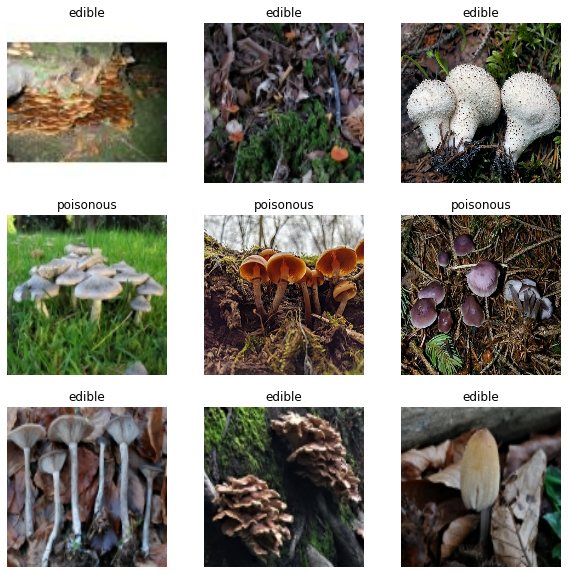

In [ ]:
# retrieve class names from dataset
class_names = train_ds.class_names

# plot first 9 images from training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
# use buffered prefetching so I/O doesn't become blocking
AUTOTUNE = tf.data.AUTOTUNE

# dataset.cache() keeps images in memory after they're loaded off disk during the first epoch
# dataset.prefetch() overlaps data preprocessing and model execution while training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Since this dataset is very small for deep learning, I'll use data augmentation to increase the number of images my model will have access to. 

Below I've defined an augmentation regimen to be used just for the purpose of visualization. The model will use the same regimen, but augmentation will be done by layers of the model rather than beforehand.

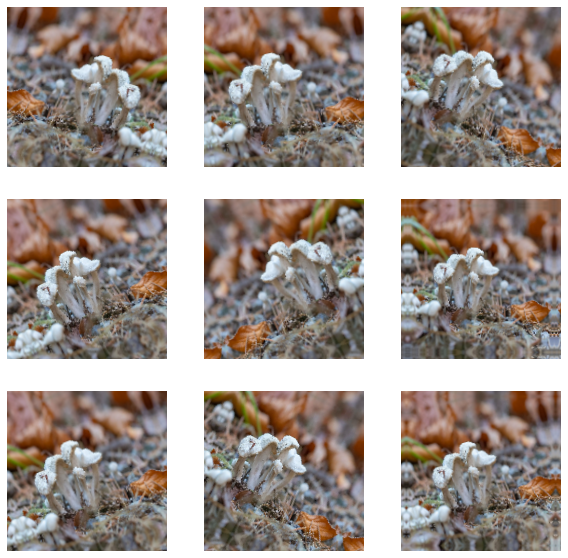

In [ ]:
# set augmentation configuration for visualizing transformations
data_augmentation = keras.Sequential([
     layers.experimental.preprocessing.RandomFlip('horizontal'),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1)
])

# run the first training image through the augmentation configuration nine times
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#@markdown ### Set epochs and learning rate
epochs =  50#@param {type: "number"}
learning_rate =  .0001#@param {type:"number"}

In [ ]:
def make_model(learning_rate):
  '''
  Returns a compiled sequential model.

  Arguments:
    learning_rate - learning rate to specify when compiling the model
  '''
  model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # next three layers are augmentation
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
  ])

  # compile the model
  opt = keras.optimizers.Adam(lr=learning_rate)
  model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
model = make_model(learning_rate)
# train model and store as history object
baseline_history = model.fit(
    train_ds,
    epochs=epochs,
    # callbacks=[early_stopping],
    validation_data=validation_ds,
)

Epoch 1/50
134/134 [==============================] - 7s 32ms/step - loss: 0.6693 - accuracy: 0.5883 - val_loss: 0.6256 - val_accuracy: 0.6287
Epoch 2/50
134/134 [==============================] - 1s 11ms/step - loss: 0.6421 - accuracy: 0.6334 - val_loss: 0.6084 - val_accuracy: 0.6772
Epoch 3/50
134/134 [==============================] - 1s 11ms/step - loss: 0.6099 - accuracy: 0.6698 - val_loss: 0.6100 - val_accuracy: 0.6511
Epoch 4/50
134/134 [==============================] - 1s 11ms/step - loss: 0.6144 - accuracy: 0.6727 - val_loss: 0.6158 - val_accuracy: 0.6549
Epoch 5/50
134/134 [==============================] - 1s 11ms/step - loss: 0.6074 - accuracy: 0.6581 - val_loss: 0.6142 - val_accuracy: 0.6623
Epoch 6/50
134/134 [==============================] - 1s 11ms/step - loss: 0.6119 - accuracy: 0.6566 - val_loss: 0.6061 - val_accuracy: 0.6474
Epoch 7/50
134/134 [==============================] - 1s 11ms/step - loss: 0.6033 - accuracy: 0.6842 - val_loss: 0.6101 - val_accuracy: 0.6567

In [ ]:
def plot_metrics(history):
  '''
  Plots accuracy and loss over epochs for both training and validation data.

  Arguments:
    history - trained model stored as a history object
  '''
  # get training and validation accuracy from the history object
  tr_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  # get training and validation loss from the history object
  tr_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # plot accuracy and loss over epochs
  epochs_range = range(epochs)

  plt.figure(figsize=(10,10))
  plt.subplot(2,1,1)
  plt.plot(history.epoch, tr_acc, label=('Training Accuracy'))
  plt.plot(history.epoch, val_acc, label=('Validation Accuracy'))
  plt.legend(loc='lower right')
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.title('Training and Validation Accuracy')


  plt.subplot(2,1,2)
  plt.plot(history.epoch, tr_loss, label='Training Loss')
  plt.plot(history.epoch, val_loss, label='Validation Loss')
  plt.legend(loc='upper left')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')

  plt.show()

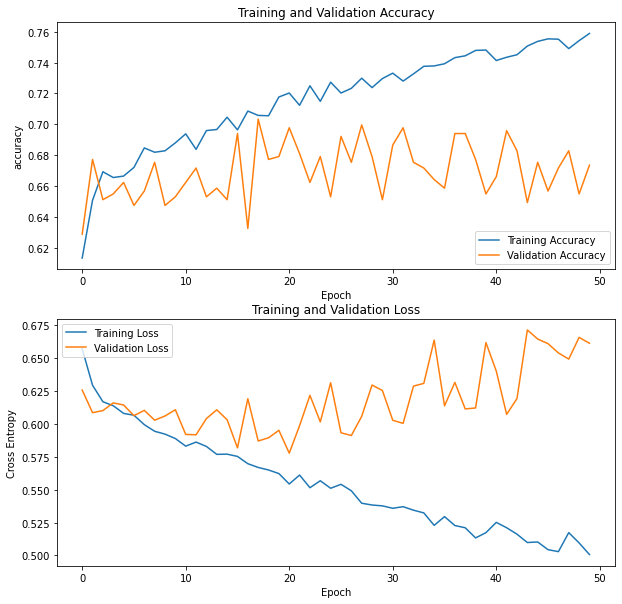

In [ ]:
# plot this model's loss and accuracy
plot_metrics(baseline_history)

In [ ]:
# generate list of labels from the validation set
true_labels = tf.concat([y for x, y in validation_ds], axis=0)
# repeat for test set
test_labels = tf.concat([y for x, y in test_ds], axis=0)

This model does not perform as well as I would like it to. This isn't surprising, given the limited amount of data available. 

When working with small datasets, one option to increase performace is transfer learning. Transfer learning uses a pre-trained model as the base for a new model, and allows the new model to use what the pre-trained model learned from training on large amounts of data.

I'll try using the pre-trained model MobileNetV2 as the base of my model. This model is not as robust as some, but it is considerably lighter and would be more suitable if I were to create a mobile app. MobileNetV2 is trained on images from ImageNet, and has trained on many types of mushrooms before.

To begin the process, I need to rescale the pixel values into the range that MobileNetV2 expects ( [-1, 1] ). The model includes a preprocesser that will do this for me.

In [ ]:
# create layer to rescale pixel values using built-in preprocessor
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# create base model from MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# create augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

The feature extractor below converts each image from its current dimensions (160x160x3) into a block of features with dimensions 5x5x1280.

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
# freeze convolutional base so that weights will not be updated during training
base_model.trainable = False

In [ ]:
# create layer to average each image's features and convert them into a 1280x1 vector
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Notice that the Dense layer below does not have an activation function. This is because predictions will be treated as raw prediction values: positive numbers = class 1, negative numbers = class 0.

In [ ]:
# Dense layer condenses features into one prediction per image 
prediction_layer = keras.layers.Dense(1) 
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Using the Keras Functional API, we can link the all of the layers created above. This API is useful since it allows us to chain together several types of layers.

In [ ]:
inputs = keras.Input(shape=(input_shape))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
tl_model = keras.Model(inputs, outputs)

In [ ]:
# define the optimizer and compile the model
opt = keras.optimizers.Adam(lr=learning_rate)
tl_model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# generate accuracy and loss predictions for this model
loss0, accuracy0 = tl_model.evaluate(validation_ds)
print('Initial loss: {:.2f}'.format(loss0))
print('Initial accuracy: {:.2f}'.format(accuracy0))

17/17 [==============================] - 2s 16ms/step - loss: 0.6657 - accuracy: 0.6902
Initial loss: 0.82
Initial accuracy: 0.44


In [ ]:
# fit model and save as a history object
transfer_history = tl_model.fit(train_ds,
                             epochs=epochs,
                             validation_data=validation_ds)

Epoch 1/50
134/134 [==============================] - 5s 15ms/step - loss: 0.7578 - accuracy: 0.5289 - val_loss: 0.6862 - val_accuracy: 0.5429
Epoch 2/50
134/134 [==============================] - 2s 15ms/step - loss: 0.7053 - accuracy: 0.5767 - val_loss: 0.6583 - val_accuracy: 0.5858
Epoch 3/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6840 - accuracy: 0.5894 - val_loss: 0.6377 - val_accuracy: 0.5970
Epoch 4/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6559 - accuracy: 0.6151 - val_loss: 0.6233 - val_accuracy: 0.5989
Epoch 5/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6418 - accuracy: 0.6196 - val_loss: 0.6114 - val_accuracy: 0.6101
Epoch 6/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6328 - accuracy: 0.6273 - val_loss: 0.6031 - val_accuracy: 0.6231
Epoch 7/50
134/134 [==============================] - 2s 15ms/step - loss: 0.6276 - accuracy: 0.6390 - val_loss: 0.5966 - val_accuracy: 0.6306

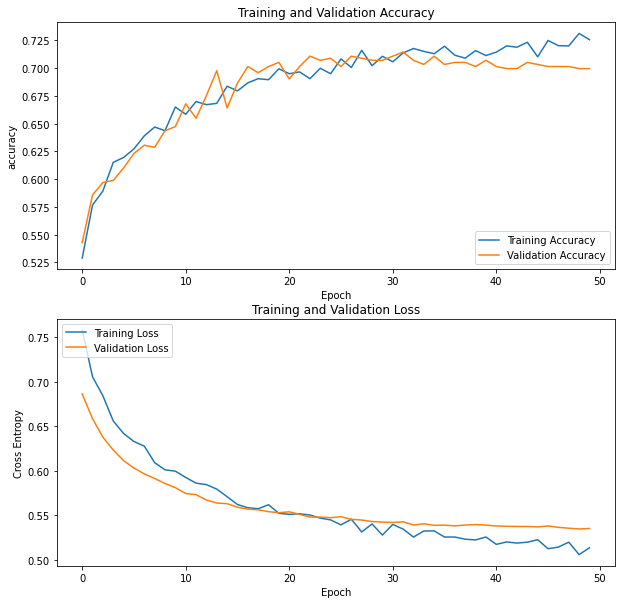

In [ ]:
plot_metrics(transfer_history)

Although the validation accuracy of this model isn't significantly different from the last model, we're seeing much less overfitting here. I'll try fine tuning the model to see if I can get better performance. 

In the model above, I left all of the convolutional layers of the base model frozen. Now, during fine tuning, I'll unfreeze some of the layers and train them, while keeping the rest frozen. This allows my model to get the generalizable information from the base model, but also learn specific information about my data.

In [ ]:
base_model.trainable = True

In [ ]:
# print out number of layers in base model
print('The base model has {} layers'.format(len(base_model.layers)))

# fine-tune layers after this
fine_tune_at = 100

# freeze all layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

The base model has 154 layers


In [ ]:
# using a smaller learning rate here so the model does not overfit
tl_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy'])

In [ ]:
total_epochs = epochs+10
# fit model and save as a history object
fine_tune_history = tl_model.fit(train_ds,
                              epochs=total_epochs,
                              # start training one epoch before the last training ended
                              initial_epoch=transfer_history.epoch[-1],
                              validation_data=validation_ds)

Epoch 50/60
134/134 [==============================] - 8s 29ms/step - loss: 0.5143 - accuracy: 0.7356 - val_loss: 0.5229 - val_accuracy: 0.7071
Epoch 51/60
134/134 [==============================] - 3s 22ms/step - loss: 0.4795 - accuracy: 0.7577 - val_loss: 0.5063 - val_accuracy: 0.7015
Epoch 52/60
134/134 [==============================] - 3s 23ms/step - loss: 0.4573 - accuracy: 0.7718 - val_loss: 0.4891 - val_accuracy: 0.7481
Epoch 53/60
134/134 [==============================] - 3s 22ms/step - loss: 0.4443 - accuracy: 0.7722 - val_loss: 0.4953 - val_accuracy: 0.7481
Epoch 54/60
134/134 [==============================] - 3s 22ms/step - loss: 0.4290 - accuracy: 0.7830 - val_loss: 0.4880 - val_accuracy: 0.7313
Epoch 55/60
134/134 [==============================] - 3s 23ms/step - loss: 0.4126 - accuracy: 0.7830 - val_loss: 0.4921 - val_accuracy: 0.7780
Epoch 56/60
134/134 [==============================] - 3s 22ms/step - loss: 0.3988 - accuracy: 0.8113 - val_loss: 0.4791 - val_accuracy:

In [ ]:
# concatenate loss and accuracy for the two models
acc = transfer_history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = transfer_history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

loss = transfer_history.history['loss'] + fine_tune_history.history['loss']
val_loss = transfer_history.history['val_loss'] + fine_tune_history.history['val_loss']

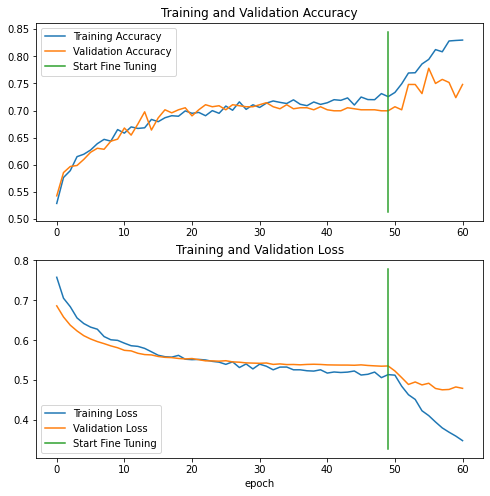

In [ ]:
# plot metrics for fine tuned model, with horizontal line to show where fine tuning began
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([epochs-1,epochs-1],
          plt.ylim(), 
         label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), 
         label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

With fine tuning the model performs even better, with validation accuracy reaching 75% during some epochs. Now I'll bring in the test data (data that was held out, not included in training or validation data) and take a look at the classification report and confusion matrix to see how well the model really performs on new data.

Classification report:

               precision    recall  f1-score   support

           0       0.73      0.86      0.79       225
           1       0.88      0.77      0.82       310

    accuracy                           0.81       535
   macro avg       0.81      0.81      0.81       535
weighted avg       0.82      0.81      0.81       535


------------------------------------------------

Poisonous Mushrooms Identified (True Negatives):  193
Poisonous Mushrooms Missed (False Positives):  32
Edible Mushrooms Identified (True Positives):  239
Edible Mushrooms Missed (False Negatives):  71


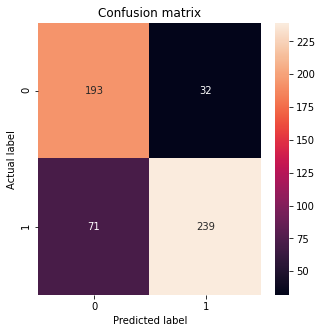

In [ ]:
# generate predictions using the transfer learning model
predictions = tl_model.predict(test_ds)
# apply a sigmoid activation function
predictions = tf.nn.sigmoid(predictions)
# binarize predictions into 0s and 1s
predictions = tf.where(predictions < 0.5, 0, 1)

print('Classification report:\n\n',classification_report(test_labels, predictions))
print('\n------------------------------------------------\n')

cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Poisonous Mushrooms Identified (True Negatives): ', cm[0][0])
print('Poisonous Mushrooms Missed (False Positives): ', cm[0][1])
print('Edible Mushrooms Identified (True Positives): ', cm[1][1])
print('Edible Mushrooms Missed (False Negatives): ', cm[1][0])

Now let's look at some of the predictions the model has made on this new data.

Predictions:
 [1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0]
Labels:
 [1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0]


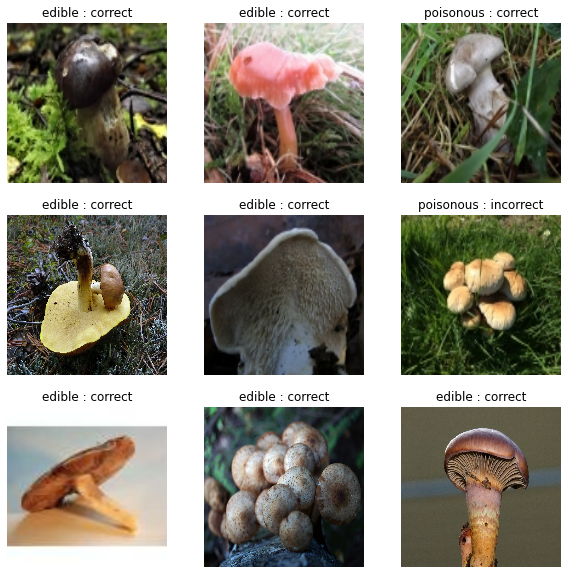

In [ ]:
# retrieve batch of images from test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = tl_model.predict_on_batch(image_batch).flatten()

# apply sigmoid since model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  if class_names[predictions[i]] == class_names[label_batch[i]]:
    plt.title('{} : correct'.format(class_names[predictions[i]]))
  else:
    plt.title('{} : incorrect'.format(class_names[predictions[i]]))
  plt.axis('off')

All in all I'm satisfied with the model's performance, especially since the original dataset was far from optimal. 

Because MobileNetV2 is a new model, significantly lighter than its predecessor MobileNetV1, this is a base that mushroom identification apps have not had access to in the past. Using MobileNetV2 as a base allowed me to create a model that could most likely be run on a smartphone without need for an external server.

I see the next steps for this project taking a couple forms. The first could be to try and increase the accuracy of the model as is, by collecting more images of the existing varieties and adding new varieties. The other path, and the one I think I will take, is to change the model from a binary classifier into a multi-class classifier capable of predicting a mushroom's variety, rather than just its edibility. This will also require significantly more data. 

I have started scouting out sources for more images and I believe I could gather a significant number from ImageNet and from Google Image searches. I would also like to include the ability for a user to input contextual data, such as what type of tree the mushroom was growing on, or what time of year the mushroom was found. 

If you're interested in seeing the work I've done on scraping from Google searches, please see the google_search_scraper in the scrapers folder of the repository. If you'd like to see some of the contextual data I've collected, please see the mushroom_information notebook.

# Resources:
---
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


https://tensorflow.org/tutorials/images/classification

https://github.com/TuomoNieminen/deep-shrooms/blob/master/deep-shrooms.ipynb

https://www.tensorflow.org/tutorials/images/transfer_learning

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://forums.fast.ai/t/google-image-scraper/79682